3001
Found 3002 files belonging to 3 classes.
Using 2702 files for training.
Found 3002 files belonging to 3 classes.
Using 300 files for validation.
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 510, 510, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 255, 255, 32)      0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2080800)           0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               266342528 
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 387       
Total params: 266,343,811
Trainable params: 266,343,811
Non-trainable params: 0
______________________

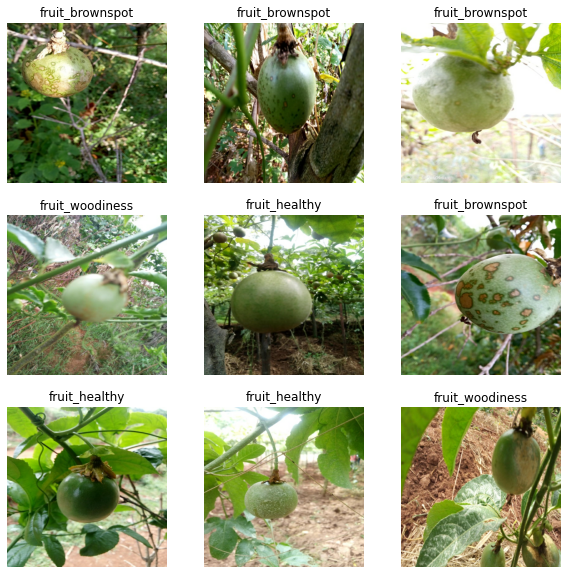

In [10]:
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import PIL
import PIL.Image
import numpy as np
import pathlib
import pandas as pd
import shutil
import matplotlib.pyplot as plt


data_dir = "train_images/Train_Images"

data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

train = pd.read_csv('Train.csv')

batch_size = 60
img_height = 512
img_width = 512

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)




val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


normalization_layer = tf.keras.layers.Rescaling(1./255)

normalize_training_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalize_training_ds))
first_image = image_batch[0]


normalized_validation_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_validation_ds))
first_image = image_batch[0]

AUTOTUNE = tf.data.AUTOTUNE

normalize_training_ds = normalize_training_ds.shuffle(image_count, reshuffle_each_iteration=True)
normalized_validation_ds = normalized_validation_ds.shuffle(int(image_count*0.15), reshuffle_each_iteration=True)


normalize_training_ds = normalize_training_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalized_validation_ds = normalized_validation_ds.cache().prefetch(buffer_size=AUTOTUNE)



num_classes = len(class_names)


model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), strides=1, activation='relu', input_shape=(512,512,3)),
    tf.keras.layers.MaxPool2D(),
    # tf.keras.layers.Conv2D(20, (3,3), strides=1, activation='relu'),
    # tf.keras.layers.MaxPool2D(2,2),
    # tf.keras.layers.Conv2D(10, 3, strides=1, activation='relu'),
    # tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)

])

model.compile(
    optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    # loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

history = model.fit(
  normalize_training_ds,
  validation_data=normalized_validation_ds,
  batch_size=60,
  epochs=5
)
